In [14]:
import os
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


#Save the file path
fasta_file_path='C:/[your directory here]/AtEPFL3_SyntenyGroup_CDS_alignment_1.fsa'


####################################>>>
# Import multi-fasta into Python and store Gene names and alignment sequences as two lists: 'fasta headers' & 'fasta sequences'
####################################>>>

fasta_headers = []
fasta_seqs = []

def unleaf_interleaved_fasta(interleaved_file):
    with open(interleaved_file, 'r') as infile:
        fasta_seq = ''
        for line in infile:
            if line.startswith('>'):
                if fasta_seq:
                    fasta_seqs.append(fasta_seq)
                    fasta_seq = ''  # Reset the sequence for the next header
                fasta_headers.append(line.split('/')[0].rstrip('\n'))
            else:
                fasta_seq += line.rstrip('\n')

        # Append the last sequence after the loop
        if fasta_seq:
            fasta_seqs.append(fasta_seq)

    return fasta_headers, fasta_seqs

fasta_headers, fasta_seqs = unleaf_interleaved_fasta(fasta_file_path)


In [15]:
fasta_seqs[0:5]

['------------------------------------------------------------------------ATGGCTTAC------TCTAGAAAGAGAAACCACCCAAAT---GGGCTAACTACT------ACATTGGTTATTCTCATCTTTTTCTTGACATTTTTACCCTTCATATCAGTTGGATTGGTTTTCTCAAGCACTAGTGAG------AAC------------------------------------------------------------------------------------------------------------------------TTCAAGCAAAAGAATTTGCAA---GTGATAGGTTCACGGCCTCCTTTGTGTGCAAACAAGTGCATGAGTTGCAACCCTTGCATGGCTGCTTTGGTA---GTTCCTCCACAT------------------------------------------------------------------------------------CAAAGGAGTCGTACTGCATCACTATGGCAAGAA---GAACAACAAGATGAAAGCTATTATCCCCTCTCCTGGAAATGCAAATGTGGGAAT---AAACTCTTCCACCCTTGA------------------------------------------------------------------------------',
 '------------------------------------------------------------------------ATGGCTCCA------TCAAAAAAATTCACAAATGGTCCA---------GCAGCT------TTTTTTGTAATTCTCAGCTTTTCATTGATGCTTCTTCCCTCCAAACCAGTTGGG------CTTGTTCTTTCCGAGTCG------GAT---GAGATTTTC---------------------------------------

In [18]:

#Provide the Beta-domain start postion (Python begins counting at zero so this is generally 1 less than what you'd see listed in an alignment file
B_start=363

#Provide the Beta-domain stop position
B_stop=723


####################################>>>
# Use indexing of B_start and B_stop to extract out the subalignment of the beta domain for each sequence in the multi-fasta
####################################>>>

B_domain=[]

for seq in fasta_seqs:
    B_domain.append(seq[B_start:B_stop])



In [17]:
#Print B_domain to ensure the right region was extracted
B_domain

['GTGATAGGTTCACGGCCTCCTTTGTGTGCAAACAAGTGCATGAGTTGCAACCCTTGCATGGCTGCTTTGGTA---GTTCCTCCACAT------------------------------------------------------------------------------------CAAAGGAGTCGTACTGCATCACTATGGCAAGAA---GAACAACAAGATGAAAGCTATTATCCCCTCTCCTGGAAATGCAAATGTGGGAAT---AAACTCTTCCACCCTTGA-----------------------------------------------------------------------------',
 'GTCTTGGGCTCAAGGCCTCCTTTGTGTGTGAACAAGTGCTTGACTTGTAGGCCTTGCATGGCTACTTTGGTA------ATTCCACCC------CATATG------------------------------------------------------------------------AAGAGCAGTACTAAAGCAACATCACAGCAGGAA---GATGAG---------AGCTATTATCTTCTCTCATGGAAATGCAGATGTGGGAAT---AAACTCTTCCAGCCTTGA-----------------------------------------------------------------------------',
 'CGGATTGGATCAAGGCCGCCGAGATGTGAAAGGAGGTGCAGTTCATGTGGTCATTGTGAGGCAGTTCAAATGCCAGCAGTCCCACAA------GATGGA---------AATGGAAGAAGACAC---------------TCTTCC---------------------------AAGGTCTCTACAATCAGTTCC---AGAGCTGCA---GACACT------TCCAACTACAAGCCCATGAGCTGGAAATGCAAATGTGGGGAT---ATGATC

In [20]:

#Provide an output path and file name to save the B_domain alignment as and where
out_path='C:/[your directory here]/AtEPFL3_SyntenyGroup_CDS_Bd.fsa'


####################################>>>
# Write out the Beta-domain subalignment as a multi-fasta after converting back into a text string, 'domain out'
####################################>>>


domain_out=''
for i in range(len(fasta_headers)):
    domain_out=domain_out+fasta_headers[i]+'\n'+B_domain[i]+'\n'
    
domain_out

with open(out_path, 'w') as file:
    # Write the string to the file
    file.write(domain_out)

In [1]:
####################################>>>
# Build a bulk PyMOL multi-PDB alignment script which can be run at once from the command line terminal at the bottom
####################################>>>
import os
import re
import numpy as np

SWISS_model_PDB_directory='C:/School/EPFL Gene Family Project/.PDB Files'

EPF_PDB_Dir=os.listdir(SWISS_model_PDB_directory)

r = re.compile(".*.pdb")
EPF_PDBs=newlist = list(filter(r.match, EPF_PDB_Dir)) 

EPF_PDBs=np.sort(EPF_PDBs)

bulk_PDB_align_pymol_script='cd '+SWISS_model_PDB_directory+'\n\nloadall *.pdb\n\n'

for PDB in EPF_PDBs:
    bulk_PDB_align_pymol_script=bulk_PDB_align_pymol_script+'extra_fit *, '+PDB.split('.pdb')[0]+', / /n   method=super, / /n   cycles=5, / /n   cutoff=2.0, / /n   mobile_state=-1, / /n   target_state=-1 /n/n'

bulk_PDB_align_pymol_script

with open(SWISS_model_PDB_directory+'Bulk_PyMOL_align.txt', 'w') as file:
    # Write the string to the file
    file.write(bulk_PDB_align_pymol_script)

In [5]:
import pandas as pd

#Read in the PyMOL PDB alignment w/ RMSD text file for a given EPF synteny cluster
PDB_align_RMSDs='C:/School/EPFL Gene Family Project/EPFL3 RSMD/RSMD EPFL3.txt'


####################################>>>
# Read in the PDB alignment text-file and convert it's RMSD information into a 2-dimensional distance matrix 'Dist_mat'
####################################>>>

with open(PDB_align_RMSDs, 'r') as infile:
        
        Prot_names=[]
        Dist_mat=np.zeros([len(EPF_PDBs),len(EPF_PDBs)])
        col_indices=[]
        col_values=[]
        
        content=False
        
        for line in infile:
            if line.startswith('PyMOL>loadall *.pdb'):
                content=True
            elif (content==True) & (line.startswith('PyMOL>extra_fit')):
                if (len(col_indices)>0):
                    Dist_mat[row_index, col_indices]=col_values
                    Prot_names.append(rowname.rstrip('\n'))
                    
                rowname=line.split(', ')[1]
                row_index=int(rowname.split('_')[0])-1
                col_indices=[]
                col_values=[]

            elif (content==True) & (not line.startswith('PyMOL')) & (not line.startswith(' Loading')):
                col_index, col_RMSD = line.split('=    ')
                col_indices.append(int(col_index.split('_')[0])-1)
                col_values.append(col_RMSD.split(' (')[0])
                
        Dist_mat[row_index, col_indices]=col_values
        Prot_names.append(rowname)
        Dist_mat=pd.DataFrame(Dist_mat, index = Prot_names, columns = Prot_names)
        


FileNotFoundError: [Errno 2] No such file or directory: 'C:/School/EPFL Gene Family Project/EPFL3 RSMD/RSMD EPFL3.txt'

In [6]:
#Print Dist_mat to ensure this operation was successful
Dist_mat

array([[0.   , 0.179, 0.148, ..., 0.   , 0.   , 0.   ],
       [0.179, 0.   , 0.462, ..., 0.   , 0.   , 0.   ],
       [0.148, 0.462, 0.   , ..., 0.   , 0.   , 0.   ],
       ...,
       [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ]])

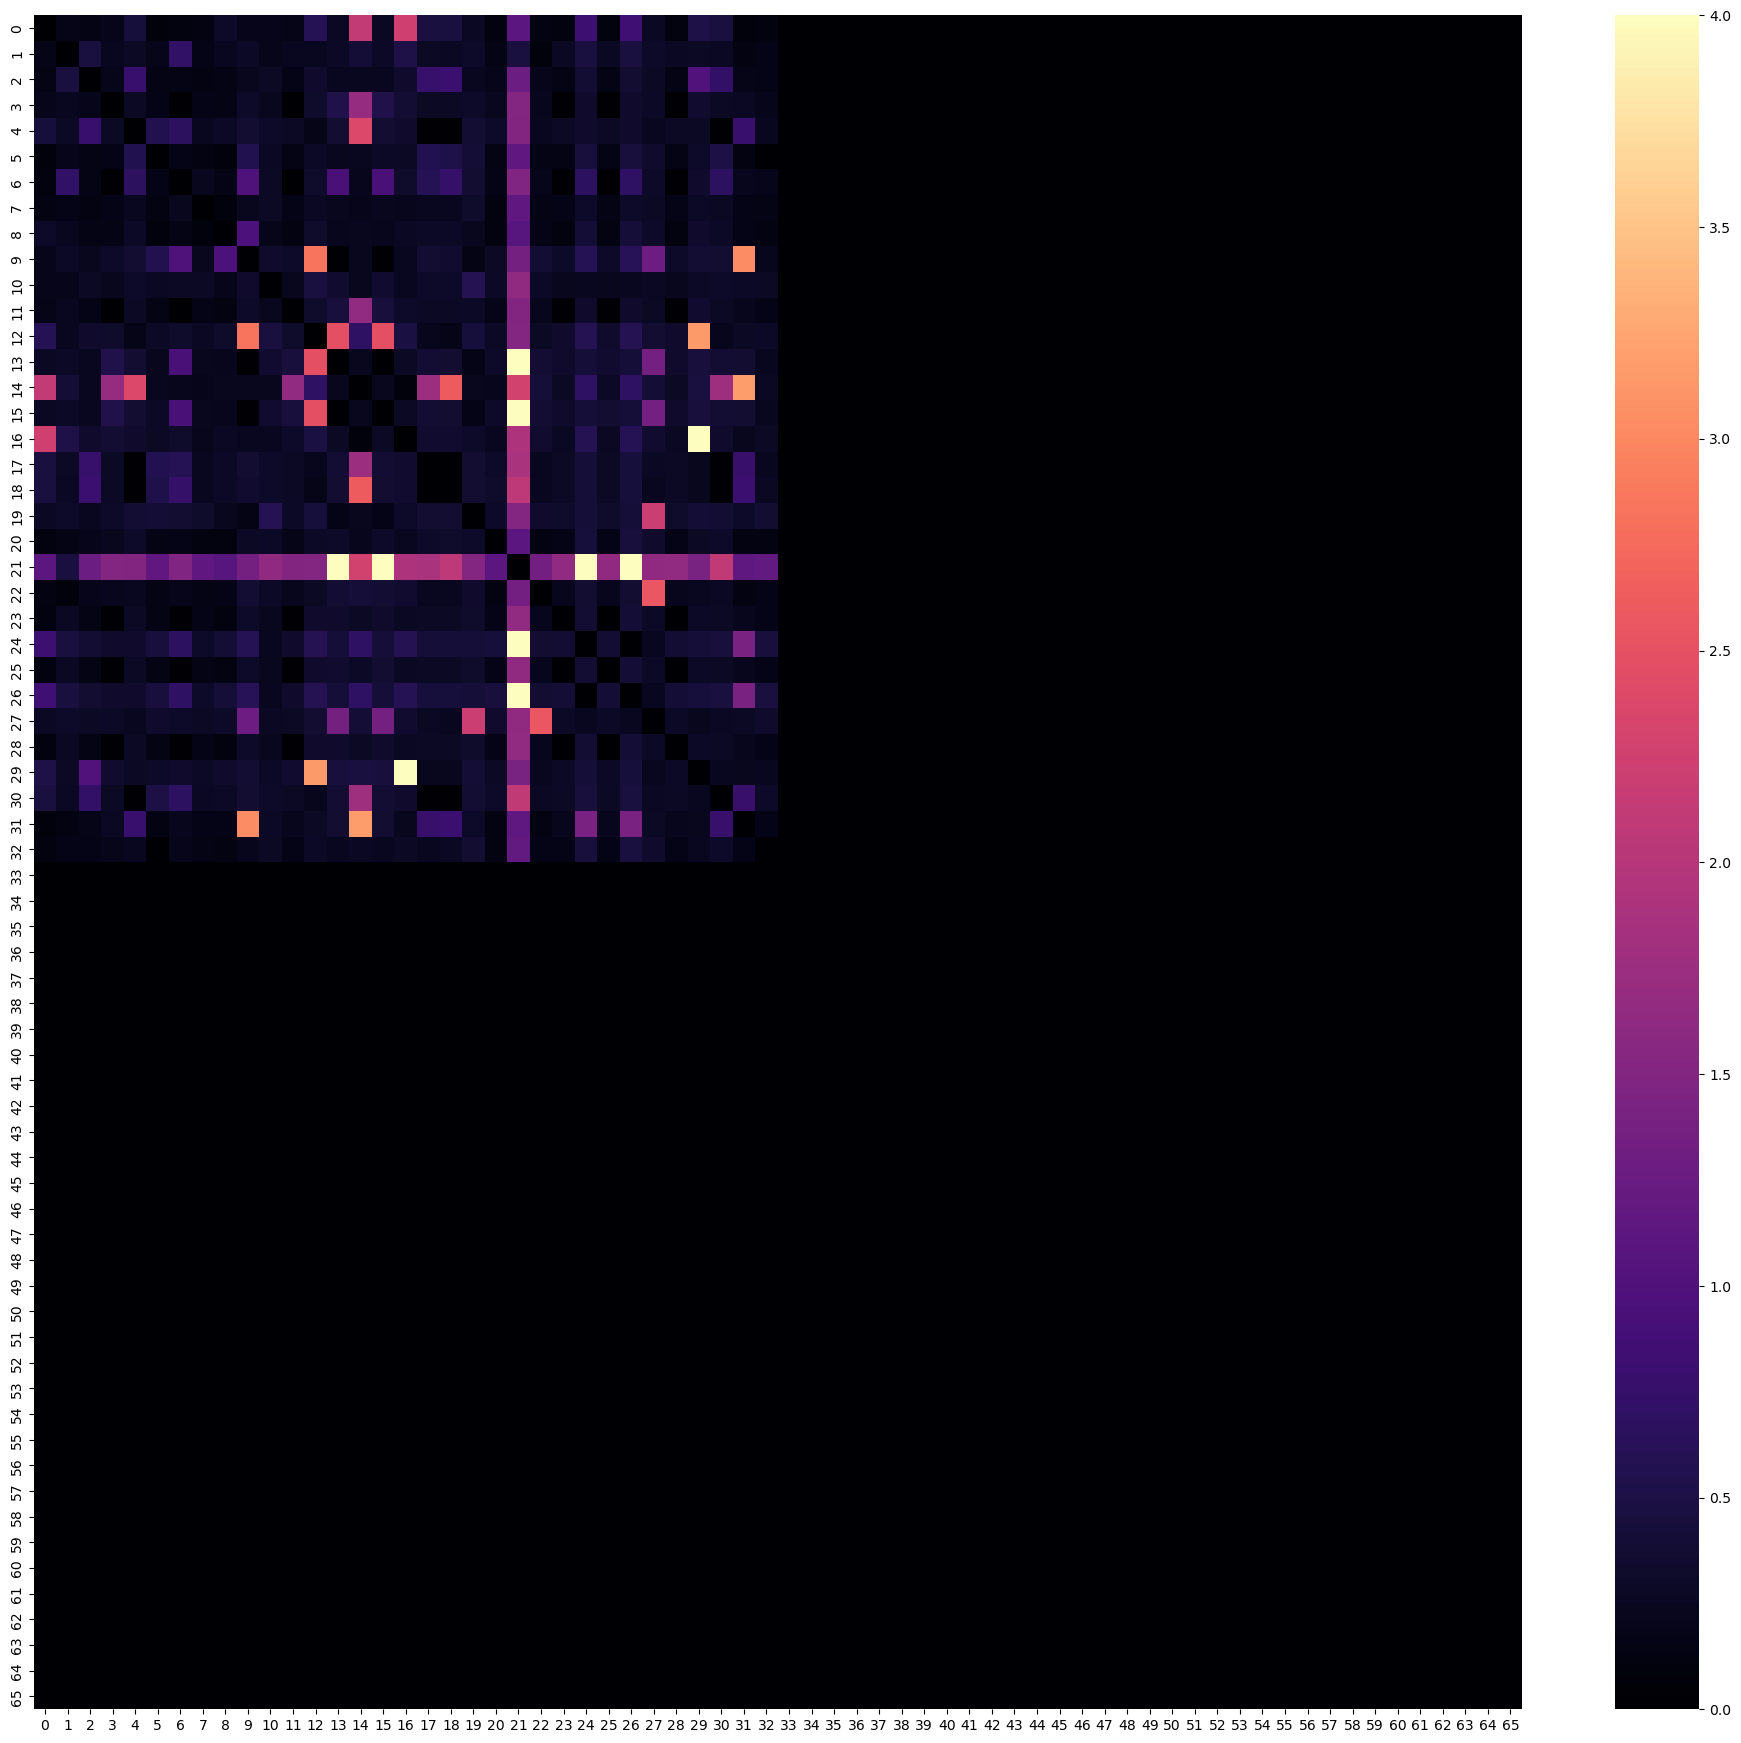

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

####################################>>>
# Visualize the Dist_mat information as a heatmap of protein-protein structural distances and save this graph as a png file
####################################>>>

fig, ax = plt.subplots(figsize=(24,22))
sns.heatmap(Dist_mat, annot=False, cmap="magma", vmin=0, vmax=4)

plt.savefig('C:/School/EPFL Gene Family Project/All EPF3/EPF3_Bdomain_align_distances_heatmap4.png')
plt.show()
